# Introduction CWRU dataset
The dataset in this notebook is from a test conducted

_additional description from readme..._


## Requirements and package install
To retrieve the data and prepare the for usage, following packages are required
* CWRU- can be installed using pip

It is recommeneded to use ```virtualenv``` and create an environment for each subproject

Once you have all packages installed, use ```pip freeze > requirements.txt``` to export required packages. 

### Dont install using ```pip```since it will install a python 2 only compatible, below code is ported to python 3

In [1]:
#package install / import code
!pip install-r requirements.txt

In [1]:
# manual install
#!pip install --user cwru
import numpy as np

/Users/opprud/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Create data folders & add to ```.gitignore```

No data is to be commited to github since it's not meant for hosting data, just code'

Therefore we add ```data```directory to git ignore list of files

In [2]:
# create a data folder if such doesnt exist
!mkdir -p data

#add the data folder to gitignore, to avoid commiting the data
gi_path = '../../../../.gitignore'

# this path, strip the part we need
dir = !pwd
dir = str(dir[0])
s = dir.split('/')
#s
# build working dir string
wd = ('\n' + s[-4] + '/' + s[-3]+ '/' + s[-2]+ '/' + s[-1] + '/data')
wd
# open and append to file
f = open(gi_path, "a")
print(wd, file=f)
f.close()

### CWRU package Usage

    import cwru
    data = cwru.CWRU("12DriveEndFault", "1797", 384)

Then, you can use ``data.X_train``, ``data.y_train``, ``data.X_test``, ``data.y_test``, ``data.labels``, ``data.nclasses`` to train and evaluate your data driven fault diagnostic algrithms.

These ``.mat`` files required by your code will be automatically downloaded from `Case Western Reserve University Bearing Data Center`_, renamed properly with their corresponding class, stored in ``./data/CWRU`` directory to avoid downloading in future.

Arguments
---------

The constructor of class ``cwru.CWRU`` has three arguments:

* **exp**: experiment, supporting ``"12DriveEndFault", "12FanEndFault", "48DriveEndFault"``
* **rpm**: rpm during testing
* **length**: length of the signal slice, namely ``X_train.shape[1]``


In [3]:
import os
import glob
import errno
import random
import urllib
import numpy as np
from scipy.io import loadmat


class CWRU:

    def __init__(self, exp, rpm, length):
        if exp not in ('12DriveEndFault', '12FanEndFault', '48DriveEndFault'):
            print( "wrong experiment name: {}".format(exp))
            exit(1)
        if rpm not in ('1797', '1772', '1750', '1730'):
            print ("wrong rpm value: {}".format(rpm))
            exit(1)

        rdir = os.path.join('.','data/CWRU',exp,rpm)
        #fmeta = os.path.join(os.path.dirname(__file__), './ metadata.txt')
        fmeta = os.path.join(os.path.dirname('.'), 'metadata.txt')
        all_lines = open(fmeta).readlines()
        lines = []
        for line in all_lines:
            l = line.split()
            if (l[0] == exp or l[0] == 'NormalBaseline') and l[1] == rpm:
                lines.append(l)

        self.length = length  # sequence length
        self._load_and_slice_data(rdir, lines)
        # shuffle training and test arrays
        self._shuffle()
        self.labels = tuple(line[2] for line in lines)
        self.nclasses = len(self.labels)  # number of classes

    def _mkdir(self, path):
        try:
            os.makedirs(path)
        except OSError as exc:
            if exc.errno == errno.EEXIST and os.path.isdir(path):
                pass
            else:
                print ("can't create directory '{}''".format(path))
                exit(1)

    def _download(self, fpath, link):
        print ("Downloading to: '{}'".format(fpath))
####       urllib.URLopener().retrieve(link, fpath)
        urllib.request.urlretrieve(link,fpath)


    def _load_and_slice_data(self, rdir, infos):
        self.X_train = np.zeros((0, self.length))
        self.X_test = np.zeros((0, self.length))
        self.y_train = []
        self.y_test = []
        for idx, info in enumerate(infos):
            # directory of this file
            fdir = os.path.join(rdir, info[0], info[1])
            self._mkdir(fdir)
            fpath = os.path.join(fdir, info[2] + '.mat')
            if not os.path.exists(fpath):
                self._download(fpath, info[3].rstrip('\n'))

            mat_dict = loadmat(fpath)
            #filter() in python 3 does not return a list, 
#            key = filter(lambda x: 'DE_time' in x, mat_dict.keys())[0]
            key = list(filter(lambda x: 'DE_time' in x, mat_dict.keys()))
            
#            time_series = mat_dict[key[:, 0]
            time_series = mat_dict[key[0]][:, 0]

            idx_last = -(time_series.shape[0] % self.length)
            clips = time_series[:idx_last].reshape(-1, self.length)

            n = clips.shape[0]
            n_split = int(3 * n / 4)
 
#            print("nsplit: ")
#            print(n_split)

            self.X_train = np.vstack((self.X_train, clips[:n_split]))
            self.X_test = np.vstack((self.X_test, clips[n_split:]))
            self.y_train += [idx] * n_split
            self.y_test += [idx] * (clips.shape[0] - n_split)

    def _shuffle(self):
        # shuffle training samples
#        index = range(self.X_train.shape[0])
        index = list(range(self.X_train.shape[0]))
        random.Random(0).shuffle(index)
        self.X_train = self.X_train[index]
        self.y_train = tuple(self.y_train[i] for i in index)

        # shuffle test samples
#        index = range(self.X_test.shape[0])
        index = list(range(self.X_test.shape[0]))
        random.Random(0).shuffle(index)
        self.X_test = self.X_test[index]
        self.y_test = tuple(self.y_test[i] for i in index)


In [3]:
# instantiate a CWRU class $
# and get us drive end data @1750RPM
d1 = CWRU('12DriveEndFault','1750', 384)

## Let's take a look at the data
the returned object returns an object including test and train data

We want data from a full rotation in the bearing

In [4]:
RPM = 1750
Fs =  12000.0

N_rot = round((60*Fs)/ RPM)
N_rot

411

In [5]:
# instantiate a CWRU class $
# and get us drive end data @1750RPM
#d1 = CWRU('12DriveEndFault','1750', 384)
#get data from 2 revolutions
d1 = CWRU('12DriveEndFault','1750', 2*N_rot)

In [6]:
print(np.shape(d1.X_train))
print(np.shape(d1.X_test))
print(np.shape(d1.y_train))
print(np.shape(d1.y_test))

(2101, 822)
(703, 822)
(2101,)
(703,)


In [7]:
!pip install seaborn --upgrade

     |████████████████████████████████| 215 kB 2.5 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.9.0
    Uninstalling seaborn-0.9.0:
      Successfully uninstalled seaborn-0.9.0


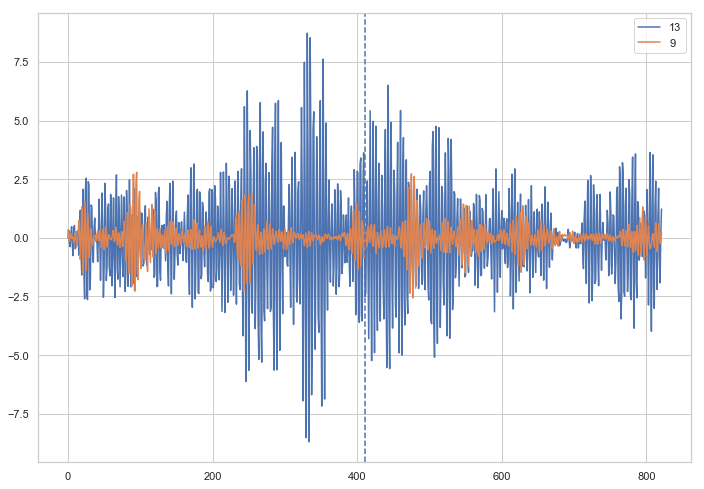

In [8]:
import numpy as np
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

# data for plot
l=len(d1.X_train[0])
x = np.arange(0,l)

y1 = d1.X_train[3]
y2 = d1.X_train[4]
l1 = str(d1.y_train[3])
l2 = str(d1.y_train[4])

#plot a few samples including labels
sns.lineplot(x,y1, palette="tab10", label=l1)
p=sns.lineplot(x,y2, palette="tab10", label=l2)
p.axvline(N_rot,ls='--',label="1 rotation")


## Package and move to a module
In the below example, i have overwritte the module in ```/Users/au263437/.local/lib/python3.6/site-packages/cwru/```
with the code above

It's probable **not** the correct way to do it according to the codestandard...

In [2]:
import cwru
d2 = cwru.CWRU('12DriveEndFault','1797', 384)

In [3]:
print(np.shape(d2.X_train))
print(np.shape(d2.X_test))
print(np.shape(d2.y_train))
print(np.shape(d2.y_test))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-16bf18b2ec19>", line 1, in <module>
    print(np.shape(d2.X_train))
NameError: name 'np' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1806, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1090, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/anaconda/lib/python3.6/site-packages/IPython/core/ultratb.py", li

NameError: name 'np' is not defined

In [106]:
max(d1.y_train)

15

In [9]:
print(np.shape(d1.y_train))
print(np.shape(d1.y_test))

(2101,)
(703,)


In [10]:
import tensorflow as tf
#from tensorflow import keras

print(tf.__version__)

2.0.0-beta1


In [12]:
from tensorflow import keras as k
from keras import utils

y_train_cat = utils.to_categorical(
    d1.y_train,
    #num_classes=(1+max(d1.y_train)),
    num_classes= 16,
    dtype='float32'
)

y_test_cat = utils.to_categorical(
    d1.y_test,
    #num_classes=(1+max(d1.y_train)),
    num_classes= 16,
    dtype='float32'
)

X_train = d1.X_train
X_test = d1.X_test

In [16]:
max(d1.y_train)

15

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Flatten, Reshape, MaxPooling1D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import os

#use GPU acceleration
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

#### from wdcnnn
BatchNorm = True # Whether to batch normalize
classes = (max(d1.y_train)+1)

# Instantiated sequential model
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], ), name='x_input'))
model.add(Reshape((int(X_train.shape[1] / 1), 1), input_shape=(X_train.shape[1], )))
# Set up the input layer, the first layer of convolution. Because you want to specify input_shape, it is released separately.#model.add(Conv1D(filters=16, kernel_size=64, strides=16, padding='same',kernel_regularizer=l2(1e-4), input_shape=input_shape))
model.add(Conv1D(filters=16, kernel_size=64, strides=16, padding='same',kernel_regularizer=regularizers.l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling1D(pool_size=2))
# second layer conv
model = wdcnn(filters=32, kernerl_size=3, strides=1, conv_padding='same',pool_padding='valid',  pool_size=2, BatchNormal=BatchNorm)
# Third layer conv
model = wdcnn(filters=64, kernerl_size=3, strides=1, conv_padding='same',pool_padding='valid', pool_size=2, BatchNormal=BatchNorm)
# Fourth layer conv
model = wdcnn(filters=64, kernerl_size=3, strides=1, conv_padding='same',pool_padding='valid', pool_size=2, BatchNormal=BatchNorm)
# Fifth layer conv
model = wdcnn(filters=64, kernerl_size=3, strides=1, conv_padding='valid',pool_padding='valid', pool_size=2, BatchNormal=BatchNorm)
# Flatten from convolution to full connection
model.add(Flatten())

# Flatten from convolution to full connection
model.add(Dense(units=100, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
# Decrease the output layer
#model.add(Dense(units=num_classes, activation='softmax', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(classes, activation='softmax', name='y_pred'))


# this controls the learning rate
opt = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

In [57]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 822, 1)            0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 52, 16)            1040      
_________________________________________________________________
batch_normalization_30 (Batc (None, 52, 16)            64        
_________________________________________________________________
activation_30 (Activation)   (None, 52, 16)            0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 52, 32)            1568      
_________________________________________________________________
batch_normalization_31 (Batc (None, 52, 32)            128       
_________________________________________________________________
activation_31 (Activation)   (None, 52, 32)           

In [58]:
from keras.callbacks import EarlyStopping

from ttictoc import TicToc
t = TicToc() ## TicToc("name")
t.tic()

# simple early stopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

start = timeit.timeit()

# train the neural network
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train, y_train_cat, batch_size=50, epochs=100, validation_data=(X_test, y_test_cat))#,callbacks=[es])

t.toc()
print(t.elapsed)
print("elapsed time WITH acceleration")


Train on 2101 samples, validate on 703 samples
Epoch 1/100
2101/2101 [==============================] - 2s 1ms/sample - loss: 1.9607 - accuracy: 0.4255 - val_loss: 2.5324 - val_accuracy: 0.2404
Epoch 2/100
2101/2101 [==============================] - 1s 320us/sample - loss: 1.0133 - accuracy: 0.7182 - val_loss: 2.5177 - val_accuracy: 0.2233
Epoch 3/100
2101/2101 [==============================] - 1s 377us/sample - loss: 0.5878 - accuracy: 0.8353 - val_loss: 2.5554 - val_accuracy: 0.2788
Epoch 4/100
2101/2101 [==============================] - 1s 412us/sample - loss: 0.4204 - accuracy: 0.8920 - val_loss: 2.3259 - val_accuracy: 0.3954
Epoch 5/100
2101/2101 [==============================] - 1s 322us/sample - loss: 0.3436 - accuracy: 0.9238 - val_loss: 1.7182 - val_accuracy: 0.4609
Epoch 6/100
2101/2101 [==============================] - 1s 291us/sample - loss: 0.2563 - accuracy: 0.9515 - val_loss: 1.1737 - val_accuracy: 0.5733
Epoch 7/100
2101/2101 [==============================] - 1s 3

In [51]:
!pip install ttictoc

### W / WO plaid ML acceleration
86.68400716781616
elapsed time NO acceleration

75.4374771118164
elapsed time WITH acceleration


## Evaluate model
predict, asess, and create a consfusion matrix

In [25]:
#X_test
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test_cat, batch_size=128)
#results = model.evaluate(X_test, Y_test, batch_size=50)
print('test loss, test acc:', results)


# Evaluate on test data
703/703 [==============================] - 0s 572us/sample - loss: 0.3576 - accuracy: 0.9388
test loss, test acc: [0.3575557671264768, 0.9388336]


In [43]:
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
import itertools

rcParams['figure.figsize'] = 15,15

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      cm = cm * 100
      print("\nNormalized confusion matrix")
    else:
      print('\nConfusion matrix, without normalization')
    print(cm)
    print ()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f' if normalize else 'd'
    #thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center")
               #,color="white" if cm[i, j] > thresh else "black")

    cmap = plt.get_cmap('jet')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


Confusion matrix, without normalization
tf.Tensor(
[[ 37   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  37   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  4   0  33   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  37   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  37   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  36   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  37   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  37   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0  36   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  37   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0  33   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0  34   0   0   0   0]
 [  0   1   3   0   2   0   0   0   0   7  16   0   8   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  37   0   0]
 [  0   0 

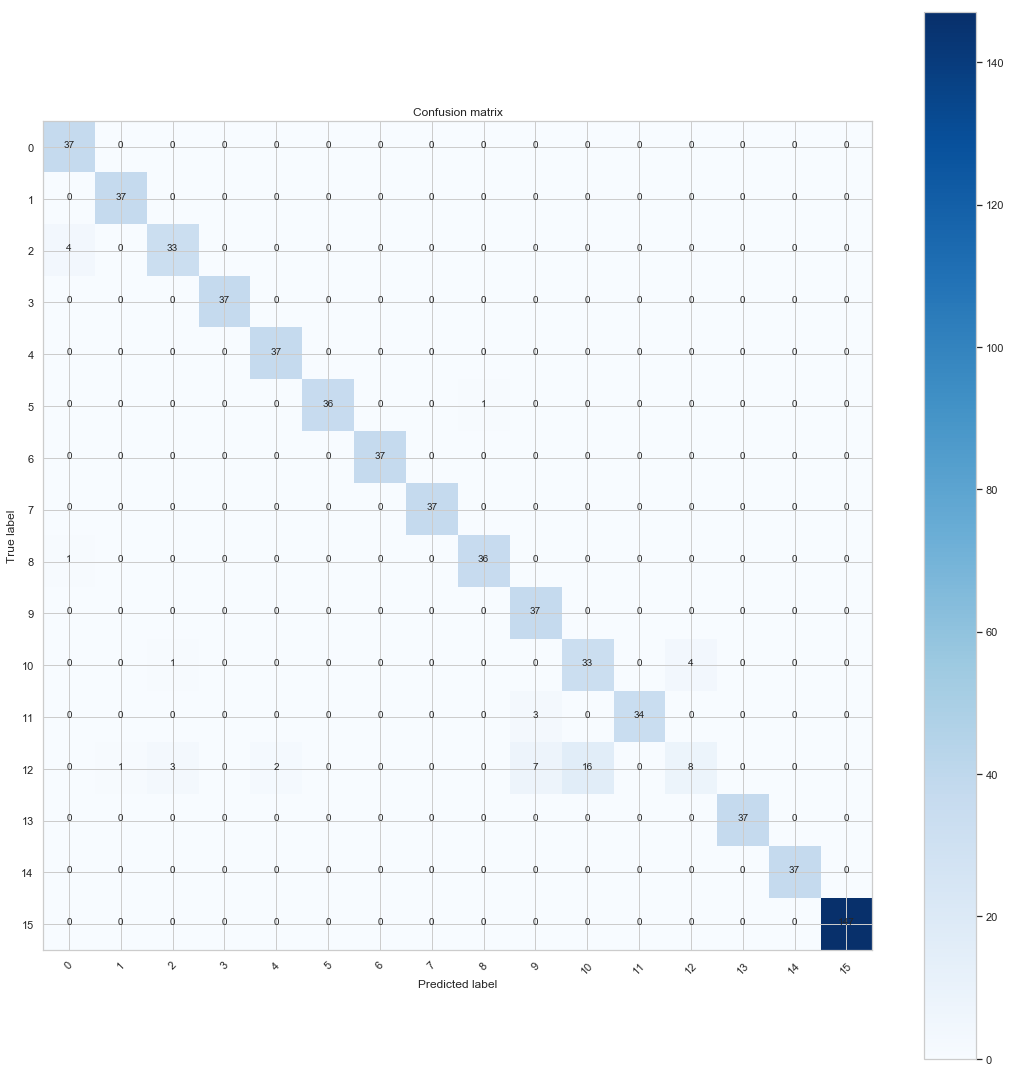

In [44]:
predictions_bin = model.predict_classes(X_test)
Y_test_classes = np.argmax(y_test_cat ,axis=1)
m=tf.math.confusion_matrix(Y_test_classes, predictions_bin)

#predictions_bin
classes_values = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15"]

plot_confusion_matrix(m,classes_values)#, normalize=True)